<a href="https://colab.research.google.com/github/VineetMakharia/NN-ipynbs/blob/main/IOT_Proj5_vrmakhar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task1 - Generating Data





In [1]:
import numpy as np
from random import seed,random
seed(200305247)

pij = [[random() for i in range(4)] for j in range(4)]
bi = [[random() for i in range(3)] for j in range(4)]
pij = np.array(pij)
bi = np.array(bi)

In [2]:
pij_normalized = pij/pij.sum(axis=1,keepdims=1)
bi_normalized = bi/bi.sum(axis=1,keepdims=1)

In [3]:
pij_normalized

array([[0.34939871, 0.27201376, 0.06268074, 0.31590679],
       [0.04198374, 0.31024784, 0.28862287, 0.35914554],
       [0.15088122, 0.0827689 , 0.53823738, 0.2281125 ],
       [0.18130768, 0.15425041, 0.37581269, 0.28862922]])

In [4]:
pij_normalized.sum(1)

array([1., 1., 1., 1.])

In [5]:
bi_normalized

array([[0.40123155, 0.2911591 , 0.30760935],
       [0.29810649, 0.18336501, 0.5185285 ],
       [0.44461846, 0.21923799, 0.33614355],
       [0.27652814, 0.49197556, 0.23149629]])

In [6]:
bi_normalized.sum(1)

array([1., 1., 1., 1.])

In [7]:
# Generating O
def generate_O(random_num, row_num):
  row_num-=1
  to_return = -1
  if random_num <= bi_normalized[row_num][0]:
    to_return = 1
  elif bi_normalized[row_num][0] < random_num <= bi_normalized[row_num][0]+bi_normalized[row_num][1]:
    to_return = 2
  else:
    to_return = 3
  
  assert (to_return!=-1)
  return to_return

In [8]:
# Generating q1
def generate_Q(random_num, row_num):
  row_num-=1
  to_return = -1
  if random_num <= pij_normalized[row_num][0]:
    to_return = 1
  elif pij_normalized[row_num][0] < random_num <= pij_normalized[row_num][0]+pij_normalized[row_num][1]:
    to_return = 2
  elif pij_normalized[row_num][0]+pij_normalized[row_num][1] < random_num <= pij_normalized[row_num][0]+pij_normalized[row_num][1] + pij_normalized[row_num][2]:
    to_return = 3
  else:
    to_return = 4
  
  assert (to_return!=-1)
  return to_return

In [9]:
q = [1]
O = [generate_O(random(),q[-1])]
for i in range(999):
  q.append(generate_Q(random(),q[-1]))
  O.append(generate_O(random(),q[-1]))


In [10]:
assert len(q) == 1000


In [11]:
assert len(O) == 1000

## Task 2 - Estimating p(O|𝝀)

In [12]:
# Ref - http://www.adeveloperdiary.com/data-science/machine-learning/forward-and-backward-algorithm-in-hidden-markov-model/
observation = [1,2,3,3,1,2,3,3,1,2,3] # Given
pi = (1,0,0,0) # Given that we are point 0

# Initially our probability will be pi*bi[0]
# So our initial probability would be [b1[0][0], 0,0,0]
# Initialization Phase
a_i = np.array(pi*bi_normalized[:,observation[0]-1])

#Recursion phase
# Since the last next only depends on previous, we can just reuse the same array
# Using formula from reference, alpha (t+1) = b[t+1]*sum(ai*alpha(t))
for t in range(1, len(observation)):
  a_i = bi_normalized[:, observation[t]-1] * a_i.dot(pij_normalized)  
print(a_i.sum())

6.405484850449832e-06


In [13]:
print(O[:12])

[3, 1, 2, 2, 3, 1, 3, 1, 1, 2, 2, 3]


## Results - 
1. In task 1, we generated seq O using the pseudo random generator from our P matrix and then got the result as [3, 1, 2, 2, 3, 1, 3, 1, 1, 2, 2, 3].

2. We were given that the original sequence of observations was [1,2,3,3,1,2,3,3,1,2,3] and we had to calculate the probability of arriving at this sequence from our "O"

3. Using the forward algorithm, we find the corresponding alpha for every time t after the first one. (During the initialization phase we know that the alpha[t] for that phase would simply be b[i]*pi <br>
[P.S. - The book states that to find the conditional probability, we only need the forward algorithm]

4. We find that the conditional probability of given sequence to the sequence we generated is 6.54*10^-6 ~= 0. This makes sense as when we observe the generated sequence vs the observed sequence, we notice that the first term itself is different. This should mean that we can never get to the the given sequence aka prob = 0

5. I have defined my alpha array as a 1-d array inorder to reduce the space complexity since we always just need the immediate previous values.

## Task 3 - Estimating the Most Probable sequence Q

In [14]:
# Using the viterbi algorithm

# Step 1 - Initialization
observation = [1,2,3,3,1,2,3,3,1,2,3]
T = len(observation)
N = pij_normalized.shape[0]

# The book states that we need to create a TxN array to store psi
# We also need a delta row which is similar to what we did for a_i in task 2

psi = np.zeros((T,N))
delta = np.zeros((T, N))
delta[0] = np.array(pi*bi_normalized[:,observation[0]-1])

# Step 2 - Recursion step
# [Book has recursion from t = 2,3...T and i=1,2...N]
# Since we are working with 0 based indexing, it will start from one lesser
for t in range(1, T):
  for i in range(0,N):
    delta[t,i] = np.max(delta[t-1] * pij_normalized[:,i]) * bi_normalized[i, observation[t]-1]
    psi[t,i] = np.argmax(delta[t-1] * pij_normalized[:,i])

# Step 3 - Calculation of optimum path
qt = [0 for i in range(T)]
qt[T-1] = np.argmax(delta[T-1])
for t in range(T-2, -1, -1):
  qt[t] = int(psi[t+1, qt[t+1]])

print("The most probable sequence of states knowing P,pi,B is -")
print([val+1 for val in qt])

The most probable sequence of states knowing P,pi,B is -
[1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [15]:
print("The generated sequence is - ")
print(q[:12])

The generated sequence is - 
[1, 1, 4, 3, 2, 3, 1, 1, 1, 4, 4, 1]


In [16]:
print("Original observation is - ")
print(observation)

Original observation is - 
[1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3]


## Results -
1. Using the viterbi algorithm is better to find the most probable sequence of states as it uses Dynamic Programming.

2. The generated sequence from task 1 is - [1, 1, 4, 3, 2, 3, 1, 1, 1, 4, 4, 1] and using O and the viterbi algorithm, we determine the most probable sequnce as - [1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3].

3. The original observation is - [1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3]. Originally, we're at point 1 and we have 4 choices for the next state. Looking at the pij_normalized matrix we can see that the 2 highest probabilites are for staying on state 1 and the next highest one is moving to state 4.

4. Thus, post computation, we can say that the most probable sequence was the one we observed.


## Task 4 - Train the HMM

In [17]:
!pip install hmmlearn

In [18]:
# Ref - https://stackoverflow.com/questions/35806469/fitting-data-to-hmm-multinomialhmm
from hmmlearn.hmm import MultinomialHMM
map = {1:0,2:1,3:2}
new_O = [map[val] for val in O]
model = MultinomialHMM(n_components=4, random_state=200305247)
X = (np.atleast_2d(new_O))
model.fit(X)

print(model.startprob_)
print('---------')
print(model.transmat_)
print('---------')
print(model.emissionprob_)
print()
print("ORIGINAL")
print(np.array(pi))
print('---------')
print(pij_normalized)
print('---------')
print(bi_normalized)

[9.12205695e-01 8.64188250e-02 3.11750152e-05 1.34430506e-03]
---------
[[0.24057523 0.29795914 0.21688024 0.24458539]
 [0.21701765 0.28569463 0.24071877 0.25656895]
 [0.2307025  0.27483451 0.24133901 0.25312398]
 [0.22554552 0.27858557 0.24138269 0.25448622]]
---------
[[1.35691955e-01 3.83098766e-01 4.81209279e-01]
 [6.35349310e-01 2.46181371e-04 3.64404509e-01]
 [2.39245124e-01 5.93248049e-01 1.67506827e-01]
 [3.97572843e-01 3.59921861e-01 2.42505296e-01]]

ORIGINAL
[1 0 0 0]
---------
[[0.34939871 0.27201376 0.06268074 0.31590679]
 [0.04198374 0.31024784 0.28862287 0.35914554]
 [0.15088122 0.0827689  0.53823738 0.2281125 ]
 [0.18130768 0.15425041 0.37581269 0.28862922]]
---------
[[0.40123155 0.2911591  0.30760935]
 [0.29810649 0.18336501 0.5185285 ]
 [0.44461846 0.21923799 0.33614355]
 [0.27652814 0.49197556 0.23149629]]


## Results -
1. Post Training the hmm model, the  determined (P,pi,B) are shown in the results above.

2. Comparing the pi, we can see that the trained model gave the highest start prob to state 1 (p=0.9) which corresponds well with our original data of starting at state 1 with prob=1.

3. Comparing the transmission probabilities, our values seem to be close to the original. For example for the state 1, our values for moving to state 2 and 4 are very close to the original. Similarly, there are several other instances where the transmission probabilites are close to the original.

4. Comparing the emission probabiliteis, a similar conclusion can be formed as above.

5. Thus, we can say that our model fit will for the generated data.


## Extra Credit -

In [19]:
import matplotlib.pyplot as plt

In [20]:
AIC = lambda l,p1: -2*(l) + 2*p1
BIC = lambda l,p1,T : -2*(l) + p1*(np.log(len(T)))
p = lambda n,m : m**2 + (n*m) -1

In [21]:
# Generating 3000 observations
O_new = [generate_O(random(),q[-1]) for i in range(3000)]
new_O_1 = [map[val] for val in O_new]

In [22]:
# https://github.com/hmmlearn/hmmlearn/issues/220#issuecomment-335044606
# model.score already return log liklelihood, no need to take log again
aic = []
bic = []
likelihood = []
num_objects=3
for n in range(2,50):
    model = MultinomialHMM(n_components=n, random_state=200305247)
    X = (np.atleast_2d(new_O_1))
    model.fit(X)
    l = model.score(X)
    p_return = p(n,num_objects)
    calc_aic = AIC(l, p_return)
    calc_bic = BIC(l,p_return,observation)
    print(f'likelihood: {l}, AIC: {calc_aic}, BIC: {calc_bic}')
    likelihood.append(l)
    aic.append(calc_aic)
    bic.append(calc_bic)

likelihood: -3119.90431606147, AIC: 6267.80863212294, BIC: 6273.379165942118
likelihood: -3119.0824381018683, AIC: 6272.164876203737, BIC: 6278.929095841309
likelihood: -3119.3277682684356, AIC: 6278.655536536871, BIC: 6286.6134419928385
likelihood: -3119.3657498860302, AIC: 6284.7314997720605, BIC: 6293.883091046423
likelihood: -3119.365045078231, AIC: 6290.730090156462, BIC: 6301.07536724922
likelihood: -3119.37247476034, AIC: 6296.74494952068, BIC: 6308.2839124318325
likelihood: -3119.4867466789296, AIC: 6302.973493357859, BIC: 6315.706142087407
likelihood: -3119.568878659763, AIC: 6309.137757319526, BIC: 6323.064091867469
likelihood: -3119.6364099589696, AIC: 6315.272819917939, BIC: 6330.392840284278
likelihood: -3119.641768396534, AIC: 6321.283536793068, BIC: 6337.597242977801
likelihood: -3119.583554006716, AIC: 6327.167108013432, BIC: 6344.67450001656
likelihood: -3119.5319079007068, AIC: 6333.0638158014135, BIC: 6351.764893622937
likelihood: -3119.490959088145, AIC: 6338.981918

AIC graph


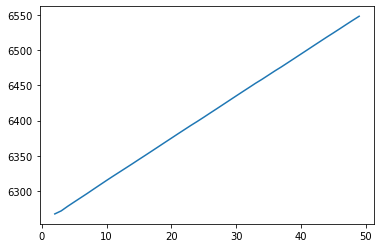

BIC Graph


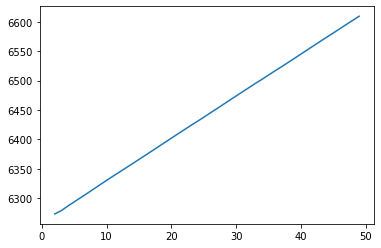

In [23]:
x = np.arange(2,50)
print("AIC graph")
plt.plot(x,aic)
plt.show()
print("BIC Graph")
plt.plot(x,bic)
plt.show()


In [24]:
bla = np.diff(likelihood)

Log Likelihood


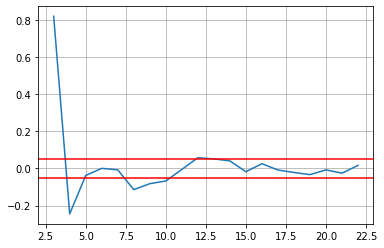

In [25]:
print("Log Likelihood")
x = np.arange(3,23,1)
plt.plot(x,bla[:20])
plt.axhline(y=0.05, color='r', linestyle='-')
plt.axhline(y=-0.05, color='r', linestyle='-')
plt.grid()
plt.show()

## Results -
1. Determining number of states is the hardest part without prior knowledge.

2. However, using the likelihood, AIC and BIC, we can determine the number of states.

3. As the number of states increases, we need more and more parameters.

4. Lower the AIC and BIC value the better it is. But we still need to get for likelihood and check when it stops decreasing.

5. Thus I felt instead of plotting the likelihood, it would be better to plot the difference between 2 consecutive likelihoods to determine how much change are we getting.

6. The red lines in the above graph represents +0.1 and -0.1 change.

7. Thus, choosing the earliest state where the consecutive difference doesn't increase by more than 0.1 from the graph, we can say that the optimal number of states is 5 since the difference is almost 0. 
